# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
from datetime import datetime as DT

In [2]:
from imod import msw
from imod import mf6

In [3]:
import primod

In [4]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM

In [5]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)

<module 'WS_Mdl.utils_imod' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\utils_imod.py'>

# Options + Basics

In [6]:
MdlN = 'NBr32'

In [7]:
U.set_verbose(False)

In [8]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

# Load PRJ

In [9]:
PRJ_, PRJ_OBS = UIM.open_PRJ_with_OBS(Pa_PRJ)

In [10]:
PRJ, period_data = PRJ_[0], PRJ_[1]

# Load DIS and limit to Mdl Aa

In [11]:
PRJ_regrid = UIM.regrid_PRJ(PRJ, MdlN)

In [12]:
BND = PRJ_regrid['bnd']['ibound']

In [13]:
# Set outer boundaries to -1 (for CHD)

# Get the coordinate indices for boundaries
y_coords = BND.y
x_coords = BND.x
first_y = y_coords.isel(y=0)  # First y coordinate
last_y = y_coords.isel(y=-1)  # Last y coordinate  
first_x = x_coords.isel(x=0)  # First x coordinate
last_x = x_coords.isel(x=-1)  # Last x coordinate

# Set boundary values using .loc indexing
BND.loc[:, first_y, :] = -1  # Top row (all layers, first y, all x)
BND.loc[:, last_y, :] = -1   # Bottom row (all layers, last y, all x)
BND.loc[:, :, first_x] = -1  # Left column (all layers, all y, first x)  
BND.loc[:, :, last_x] = -1   # Right column (all layers, all y, last x)

print("✅ Boundary conditions set successfully!")

✅ Boundary conditions set successfully!


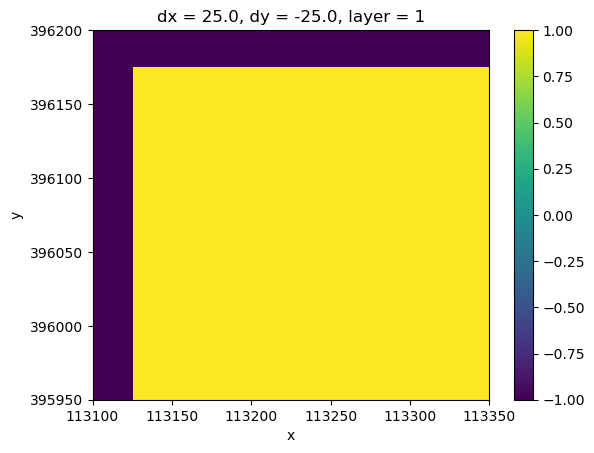

c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [14]:
BND.isel(layer=0, x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

# Load MF6 Mdl

In [15]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

Using original PRJ to load MF6 Mdl gives warnings (and it's very slow). Thus, well use the regridded PRJ, which is much faster. It can be further sped up by multi-processing, but this is not implemented yet.

In [ ]:
Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_regrid, period_data, times)

c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask

c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\code\Jupyter\test\.pixi\envs\default\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [17]:
MF6_Mdl = Sim_MF6['imported_model']

For some reason there is only 1 river system remaining. I'd expect at least 2 out of 5 (RIV and detailwatergangen) (RIV supposedly has 2, but the one that can discharge into the aquifer has a conductance of 0).

In [18]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
    
Sim_MF6["ims"] = UIM.mf6_solution_moderate_settings() # Mimic iMOD5's "Moderate" settings

# Load MSW

## 1st attempt

In [19]:
MF6_DIS = Sim_MF6["imported_model"]["dis"]  # This gets the OLD 100m grid

In [20]:
PRJ_MSW = {'cap': PRJ_regrid.copy()['cap'], 'extra': PRJ_regrid.copy()['extra']}

PRJ_regrid['cap'].keys()
for i in PRJ_regrid['cap'].keys():
    print(f" === {i} ===")
    print(PRJ_regrid['cap'][i], "\n")
x_CeCes, y_CeCes = UIM.get_CeCes_from_INI(MdlN)
PRJ['cap']['urban_area'].x.shape[0] / PRJ_regrid['cap']['urban_area'].x.shape[0]
len(x_CeCes)
PRJ['cap']['urban_area'].sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin)).plot(cmap='Spectral')
(PRJ['cap']['urban_area'].sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin)) / PRJ_regrid['cap']['urban_area']).plot(cmap='Spectral')
PRJ_regrid['cap']['urban_area'].plot(cmap='Spectral')

In [21]:
try:
    MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
    print("🎉 MetaSwap model created successfully!")
except Exception as e:
    print(f"Error creating MetaSwap model: {e}")
    MSW_Mdl = None

Error creating MetaSwap model: 
Did not find parsable path to existing .ASC file in column 2. Got
values (printing first 10): ['..\\..\\In\\CAP\\P\\NBr1\\P_20100101_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100102_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100103_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100104_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100105_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100106_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100107_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100108_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100109_NBr1.asc', '..\\..\\In\\CAP\\P\\NBr1\\P_20100110_NBr1.asc'].


## 2nd attempt

### Fix mete_grid.inp relative paths
MSW.MetaSwapModel.from_imod5_data is struggling with relative paths, so we'll convert them to full paths. #666 caution, if they're already full paths, this may cause an error.

In [22]:
# Replace the mete_grid.inp path in the PRJ_MSW_for_MSW dictionary
PRJ['extra']['paths'][2][0] = UIM.mete_grid_Cvt_to_AbsPa(Pa_PRJ, PRJ)

Created corrected mete_grid.inp: C:\Users\Karam014\OneDrive - Universiteit Utrecht\WS_Mdl\models\NBr\In\CAP\mete_grid\NBr5\temp\mete_grid.inp


### Finally load MSW Sim

In [23]:
# Create the MetaSwap model
MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_MSW, MF6_DIS, times)
print("🎉 MetaSwap model loaded successfully!")

🎉 MetaSwap model loaded successfully!


# Connect MF6 to MetaSWAP

## Clip models

In [24]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [25]:
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [26]:
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

In [27]:
print(f"MF6 Model AoI DIS shape: {MF6_Mdl_AoI['dis'].dataset.sizes}")
print(f"MSW Model AoI grid shape: {MSW_Mdl_AoI['grid'].dataset.sizes}")
print("✅ Both models successfully clipped to Area of Interest with compatible discretization!")

MF6 Model AoI DIS shape: Frozen({'layer': 37, 'y': 344, 'x': 480})
MSW Model AoI grid shape: Frozen({'x': 480, 'y': 344, 'subunit': 2})
✅ Both models successfully clipped to Area of Interest with compatible discretization!


In [28]:
MF6_Mdl_AoI['dis'].dataset.equals(MF6_Mdl['dis'].dataset)

True

clip_box doesn't clip the packages I clipped beforehand, but it clips non raster-like packages like WEL and removes packages that are not in the AoI.

#### Sense check

In [29]:
Xmin, Xmax, Ymin, Ymax

(113100.0, 125100.0, 387600.0, 396200.0)

In [30]:
MF6_Mdl_AoI['dis']['x'].min().values, MF6_Mdl_AoI['dis']['x'].max().values, \
MF6_Mdl_AoI['dis']['y'].min().values, MF6_Mdl_AoI['dis']['y'].max().values

(array(113112.5), array(125087.5), array(387612.5), array(396187.5))

Makes sense as those are cell centers.

## Load models into memory

In [31]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

## Cleanup

### MF6

In [32]:
# Create mask from current regridded model (not the old one)
mask = MF6_Mdl_AoI.domain

In [33]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### Check if the packages are the same

In [34]:
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [35]:
# Compare the keys of both models
keys_equal = MF6_Mdl.keys() == MF6_Mdl_AoI.keys()
print(f"Are the keys identical? {keys_equal}")
print()

# Get the actual keys for detailed comparison
original_keys = set(MF6_Mdl.keys())
aoi_keys = set(MF6_Mdl_AoI.keys())

print("=== DETAILED KEY COMPARISON ===")
print(f"Original model has {len(original_keys)} packages:")
for key in sorted(original_keys):
    print(f"  - {key}")

print(f"\nAoI model has {len(aoi_keys)} packages:")
for key in sorted(aoi_keys):
    print(f"  - {key}")

# Find differences
missing_in_aoi = original_keys - aoi_keys
extra_in_aoi = aoi_keys - original_keys
common_keys = original_keys & aoi_keys

print(f"\n=== DIFFERENCES ===")
if missing_in_aoi:
    print(f"Packages REMOVED in AoI model ({len(missing_in_aoi)}):")
    for key in sorted(missing_in_aoi):
        print(f"  ❌ {key}")
        # Try to understand why it was removed
        try:
            pkg = MF6_Mdl[key]
            if hasattr(pkg, 'dataset') and hasattr(pkg.dataset, 'sizes'):
                print(f"     Size in original: {dict(pkg.dataset.sizes)}")
        except:
            pass
else:
    print("✅ No packages removed in AoI model")

if extra_in_aoi:
    print(f"\nPackages ADDED in AoI model ({len(extra_in_aoi)}):")
    for key in sorted(extra_in_aoi):
        print(f"  ➕ {key}")
else:
    print("✅ No packages added in AoI model")

print(f"\nCommon packages: {len(common_keys)}/{len(original_keys)} ({100*len(common_keys)/len(original_keys):.1f}%)")

# Show why packages might be missing
if missing_in_aoi:
    print(f"\n=== WHY PACKAGES WERE REMOVED ===")
    print("Packages are typically removed from AoI models when:")
    print("1. They have no data within the clipped boundary")
    print("2. All their stress points/cells fall outside the AoI")
    print("3. The clip_box() method filters out empty packages" \
    "")
    print("\nThis is normal behavior and indicates successful spatial filtering!")

Are the keys identical? False

=== DETAILED KEY COMPARISON ===
Original model has 165 packages:
  - chd_merged
  - dis
  - drn-1
  - drn-2
  - drn-3
  - hfb-1
  - hfb-10
  - hfb-100
  - hfb-101
  - hfb-102
  - hfb-103
  - hfb-104
  - hfb-105
  - hfb-106
  - hfb-107
  - hfb-108
  - hfb-109
  - hfb-11
  - hfb-110
  - hfb-111
  - hfb-112
  - hfb-113
  - hfb-114
  - hfb-115
  - hfb-116
  - hfb-117
  - hfb-118
  - hfb-119
  - hfb-12
  - hfb-120
  - hfb-121
  - hfb-122
  - hfb-123
  - hfb-124
  - hfb-125
  - hfb-126
  - hfb-127
  - hfb-128
  - hfb-129
  - hfb-13
  - hfb-130
  - hfb-131
  - hfb-132
  - hfb-133
  - hfb-134
  - hfb-135
  - hfb-136
  - hfb-137
  - hfb-138
  - hfb-139
  - hfb-14
  - hfb-140
  - hfb-141
  - hfb-142
  - hfb-143
  - hfb-144
  - hfb-145
  - hfb-146
  - hfb-147
  - hfb-148
  - hfb-149
  - hfb-15
  - hfb-150
  - hfb-16
  - hfb-17
  - hfb-18
  - hfb-19
  - hfb-2
  - hfb-20
  - hfb-21
  - hfb-22
  - hfb-23
  - hfb-24
  - hfb-25
  - hfb-26
  - hfb-27
  - hfb-28
  - hfb-29

In [36]:
# Analyze the data content of common packages
print("=== PACKAGE DATA COMPARISON ===")
print("Comparing spatial dimensions and data ranges for common packages:\n")

for key in sorted(common_keys):
    print(f"📦 {key}:")
    try:
        orig_pkg = MF6_Mdl[key] 
        aoi_pkg = MF6_Mdl_AoI[key]
        
        # Compare dataset sizes
        if hasattr(orig_pkg, 'dataset') and hasattr(aoi_pkg, 'dataset'):
            orig_sizes = dict(orig_pkg.dataset.sizes)
            aoi_sizes = dict(aoi_pkg.dataset.sizes)
            
            print(f"   Original sizes: {orig_sizes}")
            print(f"   AoI sizes:      {aoi_sizes}")
            
            # Calculate reduction ratios
            for dim in ['x', 'y']:
                if dim in orig_sizes and dim in aoi_sizes:
                    reduction = aoi_sizes[dim] / orig_sizes[dim]
                    print(f"   {dim} reduction: {reduction:.3f} ({aoi_sizes[dim]}/{orig_sizes[dim]} cells)")
            
            # Check if data values are the same (for first few values)
            if hasattr(orig_pkg.dataset, 'data_vars') and hasattr(aoi_pkg.dataset, 'data_vars'):
                common_vars = set(orig_pkg.dataset.data_vars) & set(aoi_pkg.dataset.data_vars)
                if common_vars:
                    var = list(common_vars)[0]  # Check first variable
                    orig_data = orig_pkg.dataset[var]
                    aoi_data = aoi_pkg.dataset[var]
                    
                    # Check if AoI data is a subset of original
                    if 'x' in orig_data.dims and 'y' in orig_data.dims:
                        print(f"   Variable '{var}': Data appears to be spatially clipped ✓")
                    else:
                        print(f"   Variable '{var}': Non-spatial data")
        else:
            print("   No dataset attributes to compare")
            
    except Exception as e:
        print(f"   ⚠️  Error comparing {key}: {e}")
    
    print()  # Empty line for readability

=== PACKAGE DATA COMPARISON ===
Comparing spatial dimensions and data ranges for common packages:

📦 chd_merged:
   Original sizes: {'time': 1, 'layer': 19, 'y': 344, 'x': 480}
   AoI sizes:      {'layer': 19, 'y': 344, 'x': 480, 'time': 1}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'head': Data appears to be spatially clipped ✓

📦 dis:
   Original sizes: {'layer': 37, 'y': 344, 'x': 480}
   AoI sizes:      {'layer': 37, 'y': 344, 'x': 480}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'bottom': Data appears to be spatially clipped ✓

📦 drn-1:
   Original sizes: {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   AoI sizes:      {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   x reduction: 1.000 (480/480 cells)
   y reduction: 1.000 (344/344 cells)
   Variable 'elevation': Data appears to be spatially clipped ✓

📦 drn-2:
   Original sizes: {'layer': 1, 'y': 344, 'x': 480, 'time': 1}
   AoI sizes:      {'lay

In [37]:
# Compare coordinate bounds to verify clipping worked correctly
print("=== COORDINATE BOUNDS COMPARISON ===")
print(f"Target clipping bounds: X({Xmin:.1f}, {Xmax:.1f}), Y({Ymin:.1f}, {Ymax:.1f})")
print()

# Check DIS package bounds (most reliable for spatial extent)
if 'dis' in common_keys:
    try:
        orig_dis = MF6_Mdl['dis']
        aoi_dis = MF6_Mdl_AoI['dis']
        
        # Original bounds
        orig_x_min, orig_x_max = float(orig_dis.dataset.x.min()), float(orig_dis.dataset.x.max())
        orig_y_min, orig_y_max = float(orig_dis.dataset.y.min()), float(orig_dis.dataset.y.max())
        
        # AoI bounds  
        aoi_x_min, aoi_x_max = float(aoi_dis.dataset.x.min()), float(aoi_dis.dataset.x.max())
        aoi_y_min, aoi_y_max = float(aoi_dis.dataset.y.min()), float(aoi_dis.dataset.y.max())
        
        print("Original model bounds:")
        print(f"   X: {orig_x_min:.1f} to {orig_x_max:.1f} (range: {orig_x_max-orig_x_min:.1f})")
        print(f"   Y: {orig_y_min:.1f} to {orig_y_max:.1f} (range: {orig_y_max-orig_y_min:.1f})")
        
        print("\nAoI model bounds:")
        print(f"   X: {aoi_x_min:.1f} to {aoi_x_max:.1f} (range: {aoi_x_max-aoi_x_min:.1f})")
        print(f"   Y: {aoi_y_min:.1f} to {aoi_y_max:.1f} (range: {aoi_y_max-aoi_y_min:.1f})")
        
        # Verify clipping worked as expected
        x_within_bounds = (aoi_x_min >= Xmin-dx) and (aoi_x_max <= Xmax+dx)
        y_within_bounds = (aoi_y_min >= Ymin-dy) and (aoi_y_max <= Ymax+dy)
        
        print(f"\nClipping verification:")
        print(f"   X bounds within target: {'✓' if x_within_bounds else '✗'}")
        print(f"   Y bounds within target: {'✓' if y_within_bounds else '✗'}")
        
        if x_within_bounds and y_within_bounds:
            print("   🎉 Clipping successful!")
        else:
            print("   ⚠️  Clipping may not have worked as expected")
            
        # Calculate area reduction
        orig_area = (orig_x_max - orig_x_min) * (orig_y_max - orig_y_min)
        aoi_area = (aoi_x_max - aoi_x_min) * (aoi_y_max - aoi_y_min)
        area_ratio = aoi_area / orig_area
        
        print(f"\nArea reduction:")
        print(f"   Original area: {orig_area:,.0f} m²")
        print(f"   AoI area: {aoi_area:,.0f} m²") 
        print(f"   Ratio: {area_ratio:.4f} ({area_ratio*100:.2f}%)")
        
    except Exception as e:
        print(f"Error comparing DIS bounds: {e}")
else:
    print("DIS package not found in common keys - cannot compare bounds")

=== COORDINATE BOUNDS COMPARISON ===
Target clipping bounds: X(113100.0, 125100.0), Y(387600.0, 396200.0)

Original model bounds:
   X: 113112.5 to 125087.5 (range: 11975.0)
   Y: 387612.5 to 396187.5 (range: 8575.0)

AoI model bounds:
   X: 113112.5 to 125087.5 (range: 11975.0)
   Y: 387612.5 to 396187.5 (range: 8575.0)

Clipping verification:
   X bounds within target: ✓
   Y bounds within target: ✓
   🎉 Clipping successful!

Area reduction:
   Original area: 102,685,625 m²
   AoI area: 102,685,625 m²
   Ratio: 1.0000 (100.00%)


In [38]:
# Print the names of common packages
print("=== COMMON PACKAGES ===")
print(f"These {len(common_keys)} packages are present in both models:")
for i, key in enumerate(sorted(common_keys), 1):
    print(f"{i:2d}. {key}")

=== COMMON PACKAGES ===
These 14 packages are present in both models:
 1. chd_merged
 2. dis
 3. drn-1
 4. drn-2
 5. drn-3
 6. ic
 7. msw-rch
 8. msw-sprinkling
 9. npf
10. oc
11. riv-1riv
12. sto
13. wel-WEL_Br_Wa_T_
14. wel-WEL_Ind_Br_T


In [39]:
MF6_Mdl_AoI.keys()

KeysView(GroundwaterFlowModel(
    listing_file=None,
    print_input=False,
    print_flows=False,
    save_flows=False,
    newton=False,
    under_relaxation=False,
){
    'dis': StructuredDiscretization,
    'npf': NodePropertyFlow,
    'sto': StorageCoefficient,
    'ic': InitialConditions,
    'wel-WEL_Ind_Br_T': Well,
    'wel-WEL_Br_Wa_T_': Well,
    'msw-sprinkling': LayeredWell,
    'msw-rch': Recharge,
    'drn-1': Drainage,
    'drn-2': Drainage,
    'drn-3': Drainage,
    'riv-1riv': River,
    'chd_merged': ConstantHead,
    'oc': OutputControl,
})

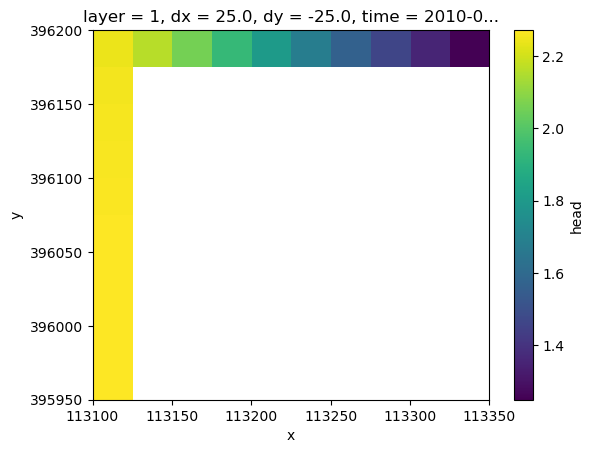

In [40]:
MF6_Mdl['chd_merged']['head'].isel(time=0, layer=0).isel(x=range(0,10), y=range(0,10)).plot.imshow(cmap='viridis')

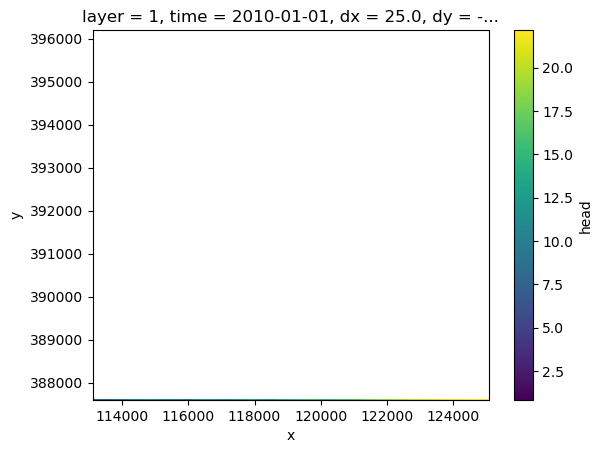

In [41]:
MF6_Mdl_AoI['chd_merged']['head'].isel(time=0, layer=0).plot.imshow(cmap='viridis')

Seems like CHD has finally been applied correctly!

This is ok. The only missing package is one of the WEL packages, which has no items in the model area.

### Cleanup MF6

In [42]:
try:
    for Pkg in [i for i in MF6_Mdl_AoI.keys() if ('riv' in i.lower()) or ('drn' in i.lower())]:
        MF6_Mdl_AoI[Pkg].cleanup(DIS_AoI)
except:
    print('Failed to cleanup packaes. Proceeding without cleanup. Fingers crossed!')

### MSW

In [43]:
# Cleanup MetaSWAP
MSW_Mdl_AoI["grid"].dataset["rootzone_depth"] = MSW_Mdl_AoI["grid"].dataset["rootzone_depth"].fillna(1.0)

## Couple

In [44]:
metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(MSW_Mdl_AoI, Sim_MF6_AoI, coupling_list=[metamod_coupling])

In [45]:
os.makedirs(d_Pa['Pa_MdlN'], exist_ok=True) # Create simulation directory if it doesn't exist

In [46]:
Pa_MF6_DLL = r"C:\OD\WS_Mdl\software\iMOD5\bin\iMOD_coupler\libmf6.dll"
Pa_MSW_DLL = r"C:\OD\WS_Mdl\software\iMOD5\bin\iMOD_coupler\MetaSWAP.dll"

In [47]:
metamod.write(directory=d_Pa['Pa_MdlN'], modflow6_dll=Pa_MF6_DLL, metaswap_dll=Pa_MSW_DLL, metaswap_dll_dependency=PDN(Pa_MF6_DLL))

TypeError: MetaSwapModel.write() missing 2 required positional arguments: 'mf6_dis' and 'mf6_wel'

# Only write MF6_Sim

coupler is failing, so let's try just MF6

In [ ]:
Sim_MF6_AoI.write(d_Pa['Pa_MdlN'])

# Junkyard

#### Test sim without cap

 <!-- # Simple solution: Remove CAP package and test if conversion works
 print("=== Testing Without CAP Package ===")

 # Create a copy of PRJ without the CAP package
 PRJ_no_MSW = PRJ.copy()
 if "cap" in PRJ_no_MSW:
     del PRJ_no_MSW["cap"]
     print("CAP package removed from PRJ")
 else:
     print("CAP package not found in PRJ")

 print(f"Original PRJ keys: {list(PRJ.keys())}")
 print(f"PRJ without CAP keys: {list(PRJ_no_MSW.keys())}")

 # Test the conversion without CAP
 try:
     print("\n=== Testing Simulation Conversion Without CAP ===")
     simulation = imod.MF6.Modflow6Simulation.from_imod5_data(PRJ_no_MSW, period_data, times)
     print("SUCCESS: Simulation created without CAP package!")
     print(f"Simulation keys: {list(simulation.keys())}")
    
     # Check what packages were created
     if "imported_model" in simulation:
         model = simulation["imported_model"]
         print(f"Model packages: {list(model.keys())}")
        
 except Exception as e:
     print(f"Error without CAP: {e}")
     import traceback
     traceback.print_exc() -->

#### Investigate well error

from imod.MF6.wel import LayeredWell, Well

PRJ['wel-WEL_Br_Wa_T_NBr1']['layer']

Well.from_imod5_data('wel-WEL_Br_Wa_T_NBr1', PRJ, times)

os.remove(Pa_PRJ_temp)  # Delete temp PRJ file as it's not needed anymore.

## Option: Subset PRJ data before conversion

You can subset the PRJ data before calling `from_imod5_data` to reduce memory usage and processing time.

### Example: Subset PRJ data before conversion to reduce memory usage
### This approach can be useful for very large models

def subset_prj_data(prj_dict, x_min, x_max, y_min, y_max):
    """
    Subset PRJ data to a specific bounding box before conversion.
    
    Parameters:
    -----------
    prj_dict : dict
        The PRJ dictionary from open_projectfile_data
    x_min, x_max, y_min, y_max : float
        Bounding box coordinates
    """
    prj_subset = {}
    
    for package_name, package_data in prj_dict.items():
        if hasattr(package_data, 'sel') and hasattr(package_data, 'dims'):
            # For xarray DataArrays with spatial dimensions
            if 'x' in package_data.dims and 'y' in package_data.dims:
                try:
                    # Subset to bounding box
                    subset_data = package_data.sel(
                        x=slice(x_min, x_max),
                        y=slice(y_max, y_min)  # Note: y is typically decreasing
                    )
                    prj_subset[package_name] = subset_data
                    print(f"Subsetted {package_name}: {package_data.sizes} -> {subset_data.sizes}")
                except Exception as e:
                    # If subsetting fails, keep original data
                    prj_subset[package_name] = package_data
                    print(f"Could not subset {package_name}: {e}")
            else:
                # Keep non-spatial data as is
                prj_subset[package_name] = package_data
        else:
            # Keep non-xarray data as is
            prj_subset[package_name] = package_data
    
    return prj_subset

### Example usage (commented out - use if needed):
### PRJ_subset = subset_prj_data(PRJ, Xmin, Xmax, Ymin, Ymax)
### Sim_MF6_subset = imod.mf6.Modflow6Simulation.from_imod5_data(PRJ_subset, period_data, times)